# Úkol č. 2 - Využití neuronových sítí

  * Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
  * Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    <br/><br/>
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

---

In [583]:
import numpy as np 
import pandas as pd
import copy
import time

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from itertools import product

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

---

# Data observation

In [252]:
df = pd.read_csv("train.csv")

In [253]:
df.head()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,0
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [254]:
df.shape

(52500, 1025)

Describing the data set to get the basic info, pixels seem to be in the boundaries (0, 255) and have no missing values

In [57]:
df.describe()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
count,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,...,52500.00000,52500.000000,52500.000000,52500.000000,52500.000000,52500.00000,52500.000000,52500.000000,52500.000000,52500.000000
mean,0.883333,0.883333,0.883333,0.883333,0.883333,0.883410,0.883467,0.883695,0.884686,0.887162,...,0.90499,0.906686,0.899943,0.889219,0.884171,0.88341,0.883352,0.883333,0.883333,4.498476
std,1.506764,1.506764,1.506764,1.506764,1.506764,1.506871,1.506957,1.507379,1.512250,1.542576,...,1.94179,2.065057,1.859559,1.594743,1.510982,1.50701,1.506784,1.506764,1.506764,2.874794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,7.000000
max,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,27.000000,66.000000,...,207.00000,206.000000,122.000000,93.000000,24.000000,11.00000,11.000000,11.000000,11.000000,9.000000


In [451]:
print(np.max(df))
print(np.min(df))

255
0


Checking for any missing values in the data set, there are none

In [60]:
df.isna().sum().sum()

np.int64(0)

Function, that for a certain array of images will show them with the label of class it belongs to

In [61]:
def plot_imgs(images: np.ndarray, titles: np.ndarray, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = np.reshape(images[i], (32, 32))
        ax.set_title(titles[i])
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

Showing 15 first images from the dataset

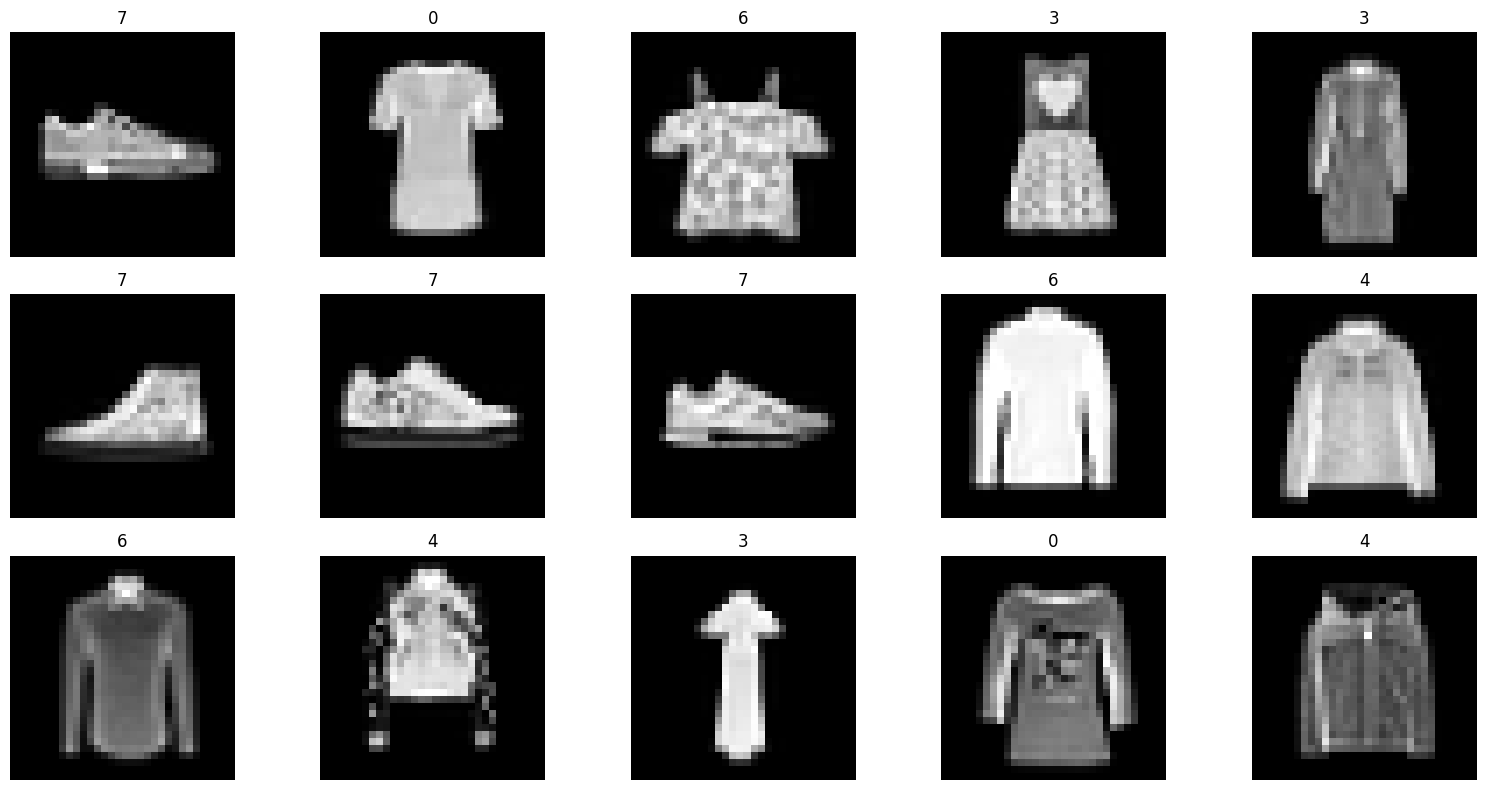

In [62]:
plot_imgs(np.array(df.iloc[:15, :1024]), np.array(df["label"]), 3, 5)

Creating custom Dataloader for the feedforward neural network

In [357]:
class TabularDataset(Dataset):
    def __init__(self, df, transform = None):
        self.X = torch.tensor(df.drop(columns=["label"]).values, dtype=torch.float32)
        self.y = torch.tensor(df["label"].values, dtype=torch.long)
        self.transform = transform
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        return x, self.y[idx]

Class that gives back normalized data

In [358]:
class Normalize:
    def __init__(self, min_val, max_val):
        self.min = torch.tensor(min_val, dtype=torch.float32)
        self.max = torch.tensor(max_val, dtype=torch.float32)

    def __call__(self, x):
        return (x - self.min) / (self.max - self.min + 1e-8)

Class that gives back standartized data

In [359]:
class Standartize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean, dtype=torch.float32)
        self.std = torch.tensor(std, dtype=torch.float32)

    def __call__(self, x):
        return (x - self.mean) / (self.std + 1e-8)

Splitting the data into the 60% train, 20% evaluation and 20% test

In [360]:
generator = torch.Generator().manual_seed(333)
dataset = TabularDataset(df)
train_data, val_data = torch.utils.data.random_split(dataset, [0.6, 0.4], generator)
val_data, test_data = torch.utils.data.random_split(val_data, [0.5, 0.5], generator)

In [361]:
print(f"The size of the train data: {len(train_data)}")
print(f"The size of the val data: {len(val_data)}")
print(f"The size of the test data: {len(test_data)}")

The size of the train data: 31500
The size of the val data: 10500
The size of the test data: 10500


---

# Feedforward neural network

Even though it is not the ideal choice (CNN should be better), FNNs can perform reasonably well with careful preprocessing, regularization, and tuning. They're also faster to train and easier to implement, making them a useful baseline

**Creating a class, that represents the neural network**

In [370]:
class Net(nn.Module):
    def __init__(self, depth: int = 1, width: int = 16, activation = nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(32*32, width))
        
        for _ in range(depth - 1):
            self.hidden_layers.append(nn.Linear(width, width))
        
        self.fc_out = nn.Linear(width, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.fc_out(x)
        return x

Defining the **loss funcion** I am going to use. Since the task involves classification to n classes, the obvios choice is CrossEntropyLoss

In [363]:
loss_fn = torch.nn.CrossEntropyLoss()

Defining the **parameters** I am going to use to tune the baseline model with no regularization

In [364]:
params = {
    "activation": [nn.ReLU(), nn.LeakyReLU(), nn.SELU()],
    "optimizer": [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adam],
    "width": [32, 64, 128],
    "depth": range(1, 6)
}

Defining the **data tranformations** I am going to use to tune models

In [365]:
df_train = df.iloc[train_data.indices]
df_val = df.iloc[val_data.indices]
df_test = df.iloc[test_data.indices]
X_train = df_train.drop(columns=["label"])

mean = X_train.mean(axis=0).values
std = X_train.std(axis=0).values
min_val = X_train.min(axis=0).values
max_val = X_train.max(axis=0).values

standardize_transform = Standartize(mean, std)
normalize_transform = Normalize(min_val, max_val)

transforms = {
    "standardize": standardize_transform,
    "normalize": normalize_transform,
    "none": None
}

First, I wanted to train models with optimizers parameters tuning, but since the training would last unreasonably long, I decided to stick with only learning rate parameter

In [366]:
# def optimizer_params(optimizer_name: str) -> dict:
#     lr = [0.1, 0.01, 0.001, 0.0001]
#     momentum = [0.5, 0.6, 0.7, 0.8, 0.9]
#     lr_decay = [0, 1, 2, 3]
#     alpha = [0.9, 0.93, 0.95, 0.97, 0.99]
#     betas = [(0.9, 0.999), (0.8, 0.888), (0.95, 0.9995)]

#     if optimizer_name == "SGD":
#         return {"lr": lr, "momentum": momentum}
#     elif optimizer_name == "ADAGrad":
#         return {"lr": lr, "lr_decay": lr_decay}
#     elif optimizer_name == "RMSProp":
#         return {"lr": lr, "alpha": alpha, "momentum": momentum}
#     return {"lr": lr, "betas": betas}

Funciton, that represents one epoch running being executed in training

In [367]:
def one_epoch(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, training_loader: torch.utils.data.DataLoader) -> tuple[float, float]:
    model.train()
    correct = 0
    total = 0
    running_cum_loss = 0.

    for X_batch, y_batch in training_loader:
        X_batch, y_batch = X_batch.to(), y_batch.to()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = X_batch.size(0)
        running_cum_loss += loss.item() * batch_size
        
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += batch_size

    avg_loss = running_cum_loss / total
    acc = correct / total
        
    return acc, avg_loss

Function, that represents one evaluation epoch

In [368]:
def eval_one_epoch(model: nn.Module, criterion: nn.Module, validation_loader: torch.utils.data.DataLoader) -> tuple[float, float]:
    model.eval()
    vcorrect = 0
    total = 0
    running_cum_vloss = 0.

    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            X_batch, y_batch = X_batch.to(), y_batch.to()
    
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            batch_size = y_batch.size(0)
            running_cum_vloss += loss.item() * batch_size
            
            _, predicted = outputs.max(1)
            vcorrect += (predicted == y_batch).sum().item()
            total += batch_size
    
    avg_vloss = running_cum_vloss / total
    vacc = vcorrect / total

    return vacc, avg_vloss 

Simple baseline model to check that everything works:

In [372]:
training_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
num_epochs = 10
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
    val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}: train accuracy = {train_acc * 100:.2f}%, val accuracy = {val_acc * 100:.2f}%, train loss: {train_loss:.2f}, val loss: {val_loss:.2f}")

Epoch 1/10: train accuracy = 25.61%, val accuracy = 29.18%, train loss: 1.93, val loss: 1.71
Epoch 2/10: train accuracy = 39.22%, val accuracy = 51.20%, train loss: 1.52, val loss: 1.35
Epoch 3/10: train accuracy = 55.83%, val accuracy = 58.90%, train loss: 1.15, val loss: 1.08
Epoch 4/10: train accuracy = 60.68%, val accuracy = 61.46%, train loss: 1.03, val loss: 0.99
Epoch 5/10: train accuracy = 63.57%, val accuracy = 60.84%, train loss: 0.97, val loss: 1.00
Epoch 6/10: train accuracy = 64.53%, val accuracy = 64.90%, train loss: 0.94, val loss: 0.92
Epoch 7/10: train accuracy = 65.83%, val accuracy = 65.30%, train loss: 0.88, val loss: 0.91
Epoch 8/10: train accuracy = 66.22%, val accuracy = 62.50%, train loss: 0.88, val loss: 0.97
Epoch 9/10: train accuracy = 66.23%, val accuracy = 65.23%, train loss: 0.87, val loss: 0.88
Epoch 10/10: train accuracy = 67.11%, val accuracy = 65.52%, train loss: 0.85, val loss: 0.90


---

## FNN with no regularization

Creating the combination of parameters for the model with no regularization

In [392]:
all_combinations = list(product(
    transforms.items(),
    params["width"],
    params["depth"],
    params["activation"],
    params["optimizer"],
    [0.1, 0.01, 0.001, 0.0001]
))

Training model:

In [395]:
num_epochs = 10
best_train_loss_net = 0.
best_val_loss_net = 0.
best_val_acc_net = 0.
best_epoch_net = 0
best_config_net = None


for (trans_name, transform), w, d, act, opt, learning_rate in tqdm(all_combinations, desc="Total Progress"):
    train_dataset = TabularDataset(df_train, transform=transform)
    val_dataset = TabularDataset(df_val, transform=transform)
    
    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    model = Net(depth=d, width=w, activation=act)
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"[{trans_name}] Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"for width={w}, depth={d}, act={act.__class__.__name__}, opt={opt.__name__}, lr={learning_rate}")

    if best_run_val_acc > best_val_acc_net:
        best_epoch_net = best_run_epoch
        best_train_loss_net = best_run_train_loss
        best_val_loss_net = best_run_val_loss
        best_val_acc_net = best_run_val_acc
        best_config_net = {
            "width": w,
            "depth": d,
            "activation": act.__class__.__name__,
            "preprocessing": trans_name,
            "optimizer": opt.__name__,
            "lr": learning_rate
        }


Total Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1620/1620 [3:56:17<00:00,  8.75s/it]


In [398]:
print(f"The best model with no regularization has val acc: {100*best_val_acc_net:.2f}%, train loss: {best_train_loss_net:.2f}, val loss: {best_val_loss_net:.2f}. At the epoch {best_epoch_net} with the params {best_config_net}")

The best model with no regularization has val acc: 88.27%, train loss: 0.32, val loss: 0.33. At the epoch 10 with the params {'width': 128, 'depth': 5, 'activation': 'SELU', 'preprocessing': 'none', 'optimizer': 'RMSprop', 'lr': 0.0001}


---

## FNN wiht early stopping regularization

Because, as can be seen, the model with no regularization ran for too long on my machine, I decided to make a cut in hyperparamaters to tune

In [402]:
params_net_es_reg = {
    "activation": [nn.ReLU(), nn.LeakyReLU(), nn.SELU()],
    "optimizer": [torch.optim.RMSprop, torch.optim.Adam],
    "width": [32, 64, 128],
    "depth": [1, 3, 5]
}

In [403]:
all_combinations_net_es_reg = list(product(
    transforms.items(),
    params_net_es_reg["width"],
    params_net_es_reg["depth"],
    params_net_es_reg["activation"],
    params_net_es_reg["optimizer"],
    [0.001, 0.0001]
))

Training model with early stopping regularization:

In [406]:
max_epochs = 15
k_epochs = 3

best_train_loss_net_es_reg = 0.
best_val_loss_net_es_reg = 0.
best_val_acc_net_es_reg = 0.
best_epoch_net_es_reg = 0
best_config_net_es_reg = None

for (trans_name, transform), w, d, act, opt, learning_rate in tqdm(all_combinations_net_es_reg, desc="Total Progress"):
    train_dataset = TabularDataset(df_train, transform=transform)
    val_dataset = TabularDataset(df_val, transform=transform)

    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    model = Net(depth=d, width=w, activation=act)
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_vloss = np.inf
    epochs_from_best = 0

    final_train_loss = 0.
    final_val_loss = 0.
    final_val_acc = 0.
    final_epoch = 0
    
    for epoch in range(1, max_epochs + 1):
        train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        final_train_loss = train_loss
        final_val_loss = val_loss
        final_val_acc = val_acc
        final_epoch = epoch

        if val_loss < best_vloss:
            best_vloss = val_loss
            epochs_from_best = 0
        else:
            epochs_from_best += 1

        if epochs_from_best > k_epochs:
            break

    # print(f"[{trans_name}] Final val acc: {100 * final_val_acc:.2f}%, val loss: {final_val_loss:.2f}, train loss: {final_train_loss:.2f}. At epoch {final_epoch}, "
    #       f"for width={w}, depth={d}, act={act.__class__.__name__}, opt={opt.__name__}, lr={learning_rate}")

    if final_val_acc > best_val_acc_net_es_reg:
        best_epoch_net_es_reg = final_epoch
        best_train_loss_net_es_reg = final_train_loss
        best_val_loss_net_es_reg = final_val_loss
        best_val_acc_net_es_reg = final_val_acc
        best_config_net_es_reg = {
            "width": w,
            "depth": d,
            "activation": act.__class__.__name__,
            "preprocessing": trans_name,
            "optimizer": opt.__name__,
            "lr": learning_rate
        }


Total Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [1:11:54<00:00, 13.32s/it]


In [433]:
print(f"The best model with early stop regularization has val acc: {100*best_val_acc_net_es_reg:.2f}%, train loss: {best_train_loss_net_es_reg:.2f}, val loss: {best_val_loss_net_es_reg:.2f}. At the epoch {best_epoch_net_es_reg} with the params {best_config_net_es_reg}")

The best model with early stop regularization has val acc: 89.58%, train loss: 0.24, val loss: 0.33. At the epoch 15 with the params {'width': 128, 'depth': 3, 'activation': 'SELU', 'preprocessing': 'standardize', 'optimizer': 'RMSprop', 'lr': 0.001}


---

## FNN with dropout regularization

Creating a new net model, with dropout regularization now

In [415]:
class NetDropout(nn.Module):
    def __init__(self, depth: int = 1, width: int = 16, activation=nn.ReLU(), dropout_prob: float = 0.5):
        super().__init__()
        self.activation = activation
        self.input_layer = nn.Linear(32*32, width)

        self.hidden_layers = nn.ModuleList()
        for _ in range(depth - 1):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(width, width),
                activation,
                nn.Dropout(p=dropout_prob)
            ))

        self.fc_out = nn.Linear(width, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.activation(self.input_layer(x))
        for block in self.hidden_layers:
            x = block(x)
        x = self.fc_out(x)
        return x

Testing if everything works fine on the simple model

In [418]:
training_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
num_epochs = 10
check = NetDropout()
optimizer = torch.optim.Adam(check.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_acc, train_loss = one_epoch(check, loss_fn, optimizer, training_loader)
    val_acc, val_loss = eval_one_epoch(check, loss_fn, validation_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}: train accuracy = {train_acc * 100:.2f}%, val accuracy = {val_acc * 100:.2f}%, train loss: {train_loss:.2f}, val loss: {val_loss:.2f}")

Epoch 1/10: train accuracy = 16.96%, val accuracy = 18.13%, train loss: 2.22, val loss: 2.10
Epoch 2/10: train accuracy = 21.07%, val accuracy = 24.91%, train loss: 1.99, val loss: 1.88
Epoch 3/10: train accuracy = 24.78%, val accuracy = 27.05%, train loss: 1.80, val loss: 1.75
Epoch 4/10: train accuracy = 26.55%, val accuracy = 26.36%, train loss: 1.73, val loss: 1.70
Epoch 5/10: train accuracy = 27.43%, val accuracy = 30.31%, train loss: 1.69, val loss: 1.67
Epoch 6/10: train accuracy = 30.87%, val accuracy = 36.09%, train loss: 1.65, val loss: 1.65
Epoch 7/10: train accuracy = 37.71%, val accuracy = 38.67%, train loss: 1.49, val loss: 1.46
Epoch 8/10: train accuracy = 39.05%, val accuracy = 38.61%, train loss: 1.45, val loss: 1.43
Epoch 9/10: train accuracy = 40.64%, val accuracy = 41.04%, train loss: 1.42, val loss: 1.43
Epoch 10/10: train accuracy = 40.92%, val accuracy = 41.70%, train loss: 1.41, val loss: 1.42


In [428]:
params_net_dp_reg = params_net_es_reg

In [429]:
all_combinations_net_dp_reg = list(product(
    transforms.items(),
    params_net_dp_reg["width"],
    params_net_dp_reg["depth"],
    params_net_dp_reg["activation"],
    params_net_dp_reg["optimizer"],
    [0.001, 0.0001],
    [0.1, 0.3, 0.5]
))

Training "*new*" (adding dropout regularization) model:

In [430]:
num_epochs = 10
best_train_loss_net_dp_reg = 0.
best_val_loss_net_dp_reg = 0.
best_val_acc_net_dp_reg = 0.
best_epoch_net_dp_reg = 0
best_config_net_dp_reg = None


for (trans_name, transform), w, d, act, opt, learning_rate, dp_prob in tqdm(all_combinations_net_dp_reg, desc="Total Progress"):
    train_dataset = TabularDataset(df_train, transform=transform)
    val_dataset = TabularDataset(df_val, transform=transform)
    
    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    model = NetDropout(depth=d, width=w, activation=act, dropout_prob=dp_prob)
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"[{trans_name}] Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"for width={w}, depth={d}, act={act.__class__.__name__}, opt={opt.__name__}, lr={learning_rate}, dropout_prob={dp_prob}")

    if best_run_val_acc > best_val_acc_net_dp_reg:
        best_epoch_net_dp_reg = best_run_epoch
        best_train_loss_net_dp_reg = best_run_train_loss
        best_val_loss_net_dp_reg = best_run_val_loss
        best_val_acc_net_dp_reg = best_run_val_acc
        best_config_net_dp_reg = {
            "width": w,
            "depth": d,
            "activation": act.__class__.__name__,
            "preprocessing": trans_name,
            "optimizer": opt.__name__,
            "lr": learning_rate,
            "dropout_prob": dp_prob
        }


Total Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [2:30:49<00:00,  9.31s/it]


In [432]:
print(f"The best model with dropout regularization has val acc: {100*best_val_acc_net_dp_reg:.2f}%, train loss: {best_train_loss_net_dp_reg:.2f}, val loss: {best_val_loss_net_dp_reg:.2f}. At the epoch {best_epoch_net_dp_reg} with the params {best_config_net_dp_reg}")

The best model with dropout regularization has val acc: 87.95%, train loss: 0.33, val loss: 0.37. At the epoch 10 with the params {'width': 128, 'depth': 1, 'activation': 'ReLU', 'preprocessing': 'standardize', 'optimizer': 'RMSprop', 'lr': 0.001, 'dropout_prob': 0.5}


---

## FNN with L1 regularization

Function, that would perform l1 regularization across all the hidden layers

In [440]:
def train_one_epoch_lreg(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, training_loader: torch.utils.data.DataLoader, l_alpha: float = 0.1) -> tuple[float, float]:
    model.train()
    correct = 0
    total = 0
    running_cum_loss = 0.

    for X_batch, y_batch in training_loader:
        X_batch, y_batch = X_batch.to(), y_batch.to()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        l_reg = torch.tensor(0., device=next(model.parameters()).device)
        for name, param in model.named_parameters():
            if "weight" in name:
                l_reg += torch.norm(param, 1)

        loss = loss + l_alpha * l_reg

        loss.backward()
        optimizer.step()

        batch_size = X_batch.size(0)
        running_cum_loss += loss.item() * batch_size

        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += batch_size
            
    avg_loss = running_cum_loss / total
    acc = correct / total
    
    return acc, avg_loss

In [448]:
params_net_l1_reg = params_net_es_reg

In [449]:
all_combinations_net_dp_reg = list(product(
    transforms.items(),
    params_net_l1_reg["width"],
    params_net_l1_reg["depth"],
    params_net_l1_reg["activation"],
    params_net_l1_reg["optimizer"],
    [0.001, 0.0001],
    [0.0001, 0.001, 0.01]
))

Training the model with L1 regularization:

In [450]:
num_epochs = 10
best_train_loss_net_l1_reg = 0.
best_val_loss_net_l1_reg = 0.
best_val_acc_net_l1_reg = 0.
best_epoch_net_l1_reg = 0
best_config_net_l1_reg = None


for (trans_name, transform), w, d, act, opt, learning_rate, l_alpha in tqdm(all_combinations_net_dp_reg, desc="Total Progress"):
    train_dataset = TabularDataset(df_train, transform=transform)
    val_dataset = TabularDataset(df_val, transform=transform)
    
    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    model = Net(depth=d, width=w, activation=act)
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = train_one_epoch_lreg(model, loss_fn, optimizer, training_loader, l_alpha)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"[{trans_name}] Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"for width={w}, depth={d}, act={act.__class__.__name__}, opt={opt.__name__}, lr={learning_rate}, l_alpha={l_alpha}")

    if best_run_val_acc > best_val_acc_net_l1_reg:
        best_epoch_net_l1_reg = best_run_epoch
        best_train_loss_net_l1_reg = best_run_train_loss
        best_val_loss_net_l1_reg = best_run_val_loss
        best_val_acc_net_l1_reg = best_run_val_acc
        best_config_net_l1_reg = {
            "width": w,
            "depth": d,
            "activation": act.__class__.__name__,
            "preprocessing": trans_name,
            "optimizer": opt.__name__,
            "lr": learning_rate,
            "l_alpha": l_alpha
        }


Total Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [2:52:28<00:00, 10.65s/it]


In [453]:
print(f"The best model with L1 regularization has val acc: {100*best_val_acc_net_l1_reg:.2f}%, train loss: {best_train_loss_net_l1_reg:.2f}, val loss: {best_val_loss_net_l1_reg:.2f}. At the epoch {best_epoch_net_l1_reg} with the params {best_config_net_l1_reg}")

The best model with L1 regularization has val acc: 86.90%, train loss: 0.60, val loss: 0.37. At the epoch 9 with the params {'width': 128, 'depth': 3, 'activation': 'ReLU', 'preprocessing': 'none', 'optimizer': 'Adam', 'lr': 0.0001, 'l_alpha': 0.0001}


---

# CNN

Creating new class for dataloader, cnn expects images in format size*size, not flattened like fnn

In [629]:
class CnnTabularDataset(Dataset):
    def __init__(self, df, transform=None, image_size=32):
        self.X = torch.tensor(df.drop(columns="label").values, dtype=torch.float32)
        self.y = torch.tensor(df["label"].values, dtype=torch.long)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        x = x.view(1, self.image_size, self.image_size)
        return x, self.y[idx]

Creating the model for conv net

In [483]:
class ConvNet(nn.Module):
    def __init__(self, depth: int = 1, width: int = 16, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation

        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=width, kernel_size=3))
        for _ in range(depth - 1):
            self.conv_layers.append(nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        size = 32
        for _ in range(depth):
            size = size - 2 
            size = size // 2

        self.flattened_size = width * size * size
        self.fc_out = nn.Linear(self.flattened_size, 10)

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(self.activation(conv(x)))
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x

Training the baseline cnn to see if everything works fine

In [484]:
train_dataset_cnn = CnnTabularDataset(df_train, image_size=32)
val_dataset_cnn = CnnTabularDataset(df_val, image_size=32)

training_loader = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset_cnn, batch_size=128, shuffle=False)
num_epochs = 10
model = ConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
    val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}: train accuracy = {train_acc * 100:.2f}%, val accuracy = {val_acc * 100:.2f}%, train loss: {train_loss:.2f}, val loss: {val_loss:.2f}")

Epoch 1/10: train accuracy = 75.77%, val accuracy = 82.39%, train loss: 1.76, val loss: 0.52
Epoch 2/10: train accuracy = 83.25%, val accuracy = 85.28%, train loss: 0.49, val loss: 0.42
Epoch 3/10: train accuracy = 85.09%, val accuracy = 85.26%, train loss: 0.42, val loss: 0.44
Epoch 4/10: train accuracy = 86.04%, val accuracy = 86.70%, train loss: 0.40, val loss: 0.40
Epoch 5/10: train accuracy = 86.81%, val accuracy = 85.89%, train loss: 0.37, val loss: 0.44
Epoch 6/10: train accuracy = 87.39%, val accuracy = 85.90%, train loss: 0.35, val loss: 0.43
Epoch 7/10: train accuracy = 87.82%, val accuracy = 87.30%, train loss: 0.34, val loss: 0.40
Epoch 8/10: train accuracy = 88.38%, val accuracy = 86.90%, train loss: 0.32, val loss: 0.42
Epoch 9/10: train accuracy = 88.44%, val accuracy = 87.02%, train loss: 0.31, val loss: 0.44
Epoch 10/10: train accuracy = 89.22%, val accuracy = 86.80%, train loss: 0.30, val loss: 0.43


As it can be seen, **even the baseline shows good results**, that fnn could give only with a big amount of hyperparamets tuned

As I my machine only has CPU, I will first tune the width, depth and transform to see what would perform best. Then with the collected I will train other hyperparameters

In [485]:
cnn_params = {
    "width": [32, 64, 128],
    "depth": range(1, 4)
}

In [486]:
all_combinations_cnnnet_simple = list(product(
    transforms.items(),
    cnn_params["width"],
    cnn_params["depth"],
))

In [488]:
num_epochs = 12
best_train_loss_cnnnet = 0.
best_val_loss_cnnnet = 0.
best_val_acc_cnnnet = 0.
best_epoch_cnnnet = 0
best_config_cnnnet = None

results_cnn_simple = []

for (trans_name, transform), w, d, in tqdm(all_combinations_cnnnet_simple, desc="Total Progress"):
    train_dataset_cnn = CnnTabularDataset(df_train, transform=transform, image_size=32)
    val_dataset_cnn = CnnTabularDataset(df_val, transform=transform, image_size=32)
    
    training_loader = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset_cnn, batch_size=128, shuffle=False)
    
    model = ConvNet(depth=d, width=w)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"[{trans_name}] Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"for width={w}, depth={d}")

    if best_run_val_acc > best_val_acc_cnnnet:
        best_epoch_cnnnet = best_run_epoch
        best_train_loss_cnnnet = best_run_train_loss
        best_val_loss_cnnnet = best_run_val_loss
        best_val_acc_cnnnet = best_run_val_acc
        best_config_cnnnet = {
            "width": w,
            "depth": d,
            "preprocessing": trans_name
        }

    results_cnn_simple.append({
        "transform": trans_name,
        "width": w,
        "depth": d,
        "val_acc": best_run_val_acc,
        "val_loss": best_run_val_loss,
        "train_loss": best_run_train_loss,
        "epoch": best_run_epoch
    })


Total Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [1:47:45<00:00, 239.47s/it]


In [489]:
print(f"The best cnn model with no regularization has val acc: {100*best_val_acc_cnnnet:.2f}%, train loss: {best_train_loss_cnnnet:.2f}, val loss: {best_val_loss_cnnnet:.2f}. At the epoch {best_epoch_cnnnet} with the params {best_config_cnnnet}")

The best cnn model with no regularization has val acc: 94.12%, train loss: 0.08, val loss: 0.24. At the epoch 12 with the params {'width': 128, 'depth': 3, 'preprocessing': 'standardize'}


In [490]:
df_cnn_simple_results = pd.DataFrame(results_cnn_simple)

In [493]:
threshold = 0.9

print("Acc > 90% per transform:")
print(df_cnn_simple_results[df_cnn_simple_results["val_acc"] > threshold]["transform"].value_counts())

print("\nAcc > 90% per depth:")
print(df_cnn_simple_results[df_cnn_simple_results["val_acc"] > threshold]["depth"].value_counts())

print("\nAcc > 90% per width:")
print(df_cnn_simple_results[df_cnn_simple_results["val_acc"] > threshold]["width"].value_counts())

Acc > 90% per transform:
transform
standardize    9
normalize      6
none           1
Name: count, dtype: int64

Acc > 90% per depth:
depth
3    6
1    5
2    5
Name: count, dtype: int64

Acc > 90% per width:
width
128    7
64     6
32     3
Name: count, dtype: int64


Plotting a graph, that would show with which parameters a certain configuration performed really well (val accurace above 0.9)

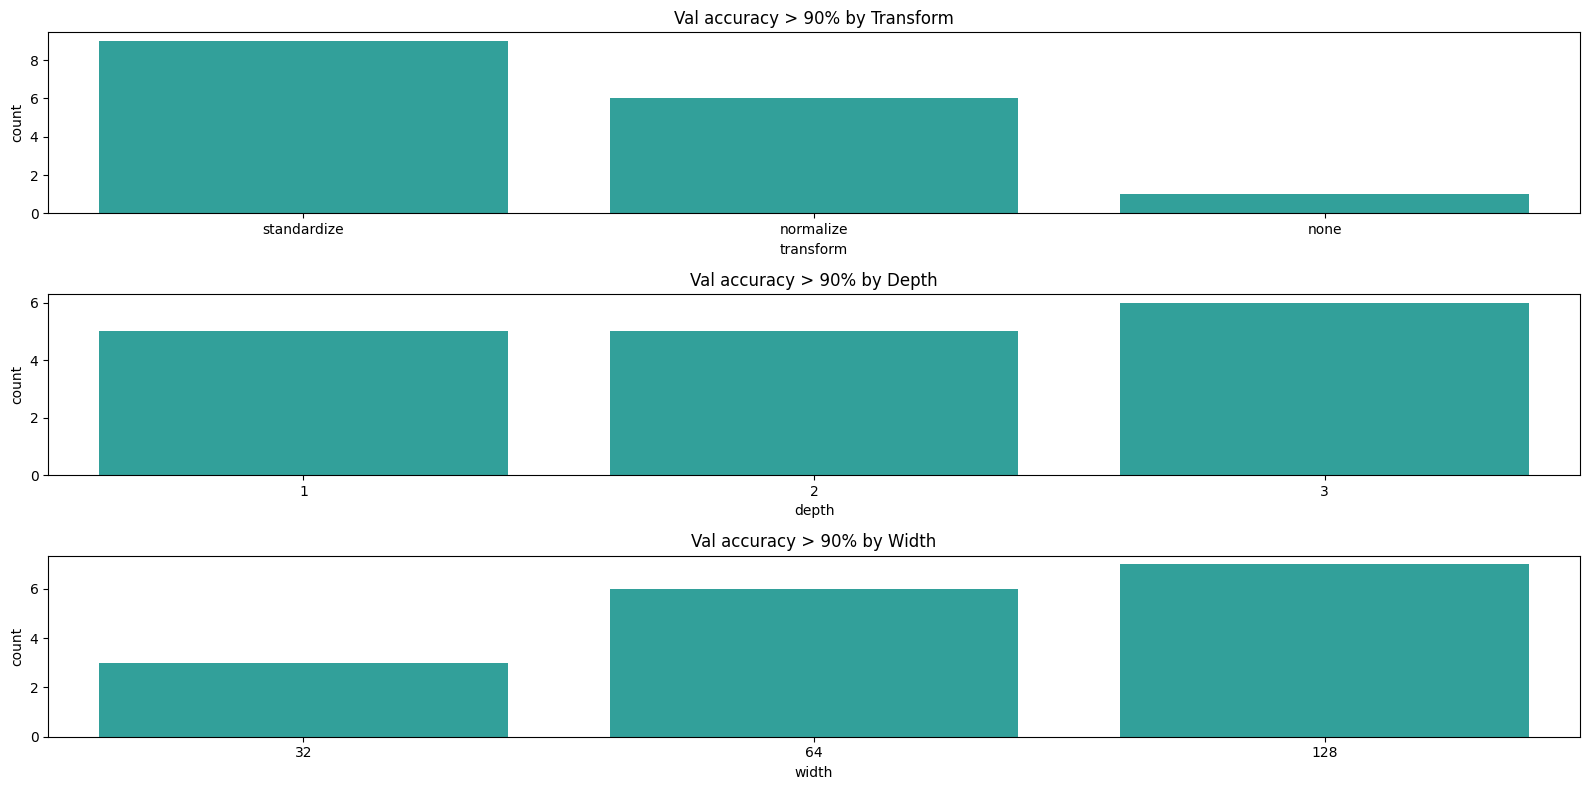

In [511]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))

sns.countplot(data=df_cnn_simple_results[df_cnn_simple_results["val_acc"] > threshold], x="transform", ax=ax1, color="lightseagreen")
ax1.set_title(f"Val accuracy > {threshold*100:.0f}% by Transform")

sns.countplot(data=df_cnn_simple_results[df_cnn_simple_results["val_acc"] > threshold], x="depth", ax=ax2, color="lightseagreen")
ax2.set_title(f"Val accuracy > {threshold*100:.0f}% by Depth")

sns.countplot(data=df_cnn_simple_results[df_cnn_simple_results["val_acc"] > threshold], x="width", ax=ax3, color="lightseagreen")
ax3.set_title(f"Val accuracy > {threshold*100:.0f}% by Width")

plt.tight_layout()
plt.show()

As we can see, the obvious winner in data transformers is **standartization**, it also performed the best in regular feedforward neural network, judjing by the best parametr of models I could achive. 
The best depth and widht seem to be **3** and **128** resp. Their combination also makes sence, judjing from previous model results

This gives me the intuition to train other hyperparametrs with chosen parameters for data transormer, depth and widht being standartization, 3 and 128 resp.

Activation functions selu and relu proved to be the best in previous runs on the feedforward neural network, as well as optimizers adam and rmsprop with the learining rate 0.001/0.0001. So I will to choose the best combinations from those 

In [540]:
cnn_params_bet = {
    "activation": [nn.ReLU(), nn.SELU()],
    "optimizer": [torch.optim.RMSprop, torch.optim.Adam],
    "lr": [0.0001, 0.001]
}

In [541]:
all_combinations_cnnnet_bet = list(product(
    cnn_params_bet["activation"],
    cnn_params_bet["optimizer"],
    cnn_params_bet["lr"]
))

In [543]:
num_epochs = 12
best_train_loss_cnnnet_bet = 0.
best_val_loss_cnnnet_bet = 0.
best_val_acc_cnnnet_bet = 0.
best_epoch_cnnnet_bet = 0
best_config_cnnnet_bet = None


for act, opt, learning_rate in tqdm(all_combinations_cnnnet_bet, desc="Total Progress"):
    train_dataset_cnn = CnnTabularDataset(df_train, transform=standardize_transform, image_size=32)
    val_dataset_cnn = CnnTabularDataset(df_val, transform=standardize_transform, image_size=32)
    
    training_loader = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset_cnn, batch_size=128, shuffle=False)
    
    model = ConvNet(depth=3, width=128, activation=act)
    optimizer = opt(model.parameters(), lr=learning_rate)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"act={act.__class__.__name__}, opt={opt.__name__}, lr={learning_rate}")

    if best_run_val_acc > best_val_acc_cnnnet_bet:
        best_epoch_cnnnet_bet = best_run_epoch
        best_train_loss_cnnnet_bet = best_run_train_loss
        best_val_loss_cnnnet_bet = best_run_val_loss
        best_val_acc_cnnnet_bet = best_run_val_acc
        best_config_cnnnet_bet = {
            "activation": act.__class__.__name__,
            "optimizer": opt.__name__,
            "lr": learning_rate
        }


Total Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [1:11:16<00:00, 534.56s/it]


In [544]:
print(f"The best cnn model with no regularization has val acc: {100*best_val_acc_cnnnet_bet:.2f}%, train loss: {best_train_loss_cnnnet_bet:.2f}, val loss: {best_val_loss_cnnnet_bet:.2f}. At the epoch {best_epoch_cnnnet_bet} with the params {best_config_cnnnet_bet}")

The best cnn model with no regularization has val acc: 94.09%, train loss: 0.11, val loss: 0.21. At the epoch 11 with the params {'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001}


---

## CNN with Dropout Regularization

Creating a model for the cnn with dropout regularization now

In [628]:
class ConvNetDropout(nn.Module):
    def __init__(self, depth: int = 1, width: int = 16, activation=nn.ReLU(), dropout_prob: float = 0.5):
        super().__init__()
        self.activation = activation
        self.conv_layers = nn.ModuleList()

        self.conv_layers.append(nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=width, kernel_size=3),
            activation,
            nn.Dropout(p=dropout_prob)
        ))

        for _ in range(depth - 1):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3),
                activation,
                nn.Dropout(p=dropout_prob)
            ))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        size = 32
        for _ in range(depth):
            size = size - 2 
            size = size // 2

        self.flattened_size = width * size * size
        self.fc_out = nn.Linear(self.flattened_size, 10)

    def forward(self, x):
        for conv_block in self.conv_layers:
            x = self.pool(conv_block(x))
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x


Training the cnn with dropout regularization

In [553]:
drop_probs = [x/10 for x in range (1, 6)]

In [554]:
num_epochs = 12
best_train_loss_cnnnet_dp = 0.
best_val_loss_cnnnet_dp = 0.
best_val_acc_cnnnet_dp = 0.
best_epoch_cnnnet_dp = 0
best_prob_cnnnet_dp = 0


for drop_prob in tqdm(drop_probs, desc="Total Progress"):
    train_dataset_cnn = CnnTabularDataset(df_train, transform=standardize_transform, image_size=32)
    val_dataset_cnn = CnnTabularDataset(df_val, transform=standardize_transform, image_size=32)
    
    training_loader = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset_cnn, batch_size=128, shuffle=False)
    
    model = ConvNetDropout(depth=3, width=128, activation=nn.ReLU(), dropout_prob=drop_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = one_epoch(model, loss_fn, optimizer, training_loader)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"prob={drop_prob}")

    if best_run_val_acc > best_val_acc_cnnnet_dp:
        best_epoch_cnnnet_dp = best_run_epoch
        best_train_loss_cnnnet_dp = best_run_train_loss
        best_val_loss_cnnnet_dp = best_run_val_loss
        best_val_acc_cnnnet_dp = best_run_val_acc
        best_prob_cnnnet_dp = drop_prob


Total Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [57:34<00:00, 690.86s/it]


In [556]:
print(f"The best cnn model with dropout regularization has val acc: {100*best_val_acc_cnnnet_dp:.2f}%, train loss: {best_train_loss_cnnnet_dp:.2f}, val loss: {best_val_loss_cnnnet_dp:.2f}. At the epoch {best_epoch_cnnnet_dp} with the dropout probability {best_prob_cnnnet_dp}")

The best cnn model with dropout regularization has val acc: 93.50%, train loss: 0.16, val loss: 0.20. At the epoch 12 with the dropout probability 0.1


---

## CNN L1 regularization

Training the cnn with l1 regularization

In [558]:
l_alphas = [0.0001, 0.001, 0.01]

In [560]:
num_epochs = 12
best_train_loss_cnnnet_l1 = 0.
best_val_loss_cnnnet_l1 = 0.
best_val_acc_cnnnet_l1 = 0.
best_epoch_cnnnet_l1 = 0
best_alpha_l1 = None


for l_alpha in tqdm(l_alphas, desc="Total Progress"):

    train_dataset_cnn = CnnTabularDataset(df_train, transform=standardize_transform, image_size=32)
    val_dataset_cnn = CnnTabularDataset(df_val, transform=standardize_transform, image_size=32)
    
    training_loader = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset_cnn, batch_size=128, shuffle=False)
    
    model = ConvNet(depth=3, width=128, activation=nn.ReLU())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_run_epoch = 0
    best_run_train_loss = 0
    best_run_val_loss = 0
    best_run_val_acc = 0.
    
    for epoch in range(1, num_epochs + 1):
        train_acc, train_loss = train_one_epoch_lreg(model, loss_fn, optimizer, training_loader, l_alpha)
        val_acc, val_loss = eval_one_epoch(model, loss_fn, validation_loader)

        if val_acc > best_run_val_acc:
            best_run_epoch = epoch
            best_run_train_loss = train_loss
            best_run_val_loss = val_loss
            best_run_val_acc = val_acc

    # print(f"[{trans_name}] Best val acc: {100*best_run_val_acc:.2f}%, val loss: {best_run_val_loss:.2f}, train loss: {best_run_train_loss:.2f}. At epoch {best_run_epoch}, "
    #       f"l_alpha={l_alpha}")

    if best_run_val_acc > best_val_acc_cnnnet_l1:
        best_epoch_cnnnet_l1 = best_run_epoch
        best_train_loss_cnnnet_l1 = best_run_train_loss
        best_val_loss_cnnnet_l1 = best_run_val_loss
        best_val_acc_cnnnet_l1 = best_run_val_acc
        best_alpha_l1 = l_alpha


Total Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [26:39<00:00, 533.24s/it]


In [561]:
print(f"The best cnn model with l1 regularization has val acc: {100*best_val_acc_cnnnet_l1:.2f}%, train loss: {best_train_loss_cnnnet_l1:.2f}, val loss: {best_val_loss_cnnnet_l1:.2f}. At the epoch {best_epoch_cnnnet_l1} with the l1 parameter {best_alpha_l1}")

The best cnn model with l1 regularization has val acc: 90.44%, train loss: 0.41, val loss: 0.27. At the epoch 12 with the l1 parameter 0.0001


---

# Choosing the best model + data evaluation

In [567]:
print(f"As the best model I choose cnn with no regularization and params: {best_config_cnnnet_bet}; {best_config_cnnnet} at epoch {best_epoch_cnnnet_bet}, as it has shown the best validation accuracy: {100*best_val_acc_cnnnet_bet:.2f}% and the train/val loss: {best_train_loss_cnnnet_bet:.2f}/{best_val_loss_cnnnet_bet:.2f}")

As the best model I choose cnn with no regularization and params: {'activation': 'ReLU', 'optimizer': 'Adam', 'lr': 0.001}; {'width': 128, 'depth': 3, 'preprocessing': 'standardize'} at epoch 11, as it has shown the best validation accuracy: 94.09% and the train/val loss: 0.11/0.21


In [569]:
train_dataset_cnn = CnnTabularDataset(df_train, transform=standardize_transform, image_size=32)
val_dataset_cnn = CnnTabularDataset(df_val, transform=standardize_transform, image_size=32)
    
training_loader = torch.utils.data.DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset_cnn, batch_size=128, shuffle=False)

best_model = ConvNet(depth=3, width=128, activation=nn.ReLU())
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

num_epochs = 11

for epoch in range(num_epochs):
    train_acc, train_loss = one_epoch(best_model, loss_fn, optimizer, training_loader)
    val_acc, val_loss = eval_one_epoch(best_model, loss_fn, validation_loader)

Result on the test data:

In [572]:
test_dataset_cnn = CnnTabularDataset(df_test, transform=standardize_transform, image_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset_cnn, batch_size=128, shuffle=False)

In [590]:
test_predictions = np.zeros(len(test_dataset_cnn))
test_y = np.zeros(len(test_dataset_cnn))
ii = 0
for vdata in tqdm(test_loader):
    vinputs, vlabels = vdata
    with torch.no_grad():
        voutputs = best_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    test_predictions[ii:(ii + vinputs.shape[0])] = voutputs.argmax(1).numpy()
    test_y[ii:(ii + vinputs.shape[0])] = vlabels.numpy()
    ii += vinputs.shape[0]
    
print(f"Test accuracy: {accuracy_score(test_y, test_predictions)}, so we can expect this accuracy on new data")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:03<00:00, 22.08it/s]

Test accuracy: 0.932952380952381, so we can expect this accuracy on new data


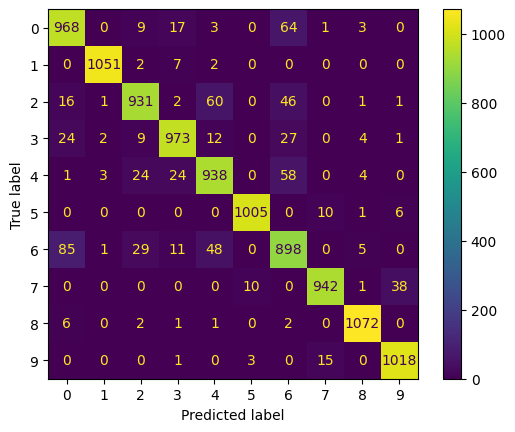

In [591]:
cnf_matrix = confusion_matrix(test_y, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

With the confusion matrix we see, that classes are well balanced, the model shows pretty good results

---

## Predictions on new data:

In [622]:
res = pd.read_csv("evaluate.csv")

In [623]:
res.isna().sum().sum()

np.int64(0)

In [624]:
ids = res.iloc[:,:1]
new_data = res.iloc[:,1:]

In [625]:
class CnnTabularDatasetT(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, image_size=32, label_column="label"):
        self.has_labels = label_column in df.columns
        self.X = torch.tensor(
            df.drop(columns=label_column, errors="ignore").values, dtype=torch.float32
        )
        if self.has_labels:
            self.y = torch.tensor(df[label_column].values, dtype=torch.long)
        else:
            self.y = None

        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
    
        if self.transform:
            x = self.transform(x)
    
        img = x.reshape(1, self.image_size, self.image_size)
    
        if self.y is not None:
            return img, self.y[idx]
        else:
            return img


In [626]:
eval_dataset = CnnTabularDatasetT(new_data, transform=standardize_transform, image_size=32)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=128, shuffle=False)

In [631]:
all_preds = []

best_model.eval()
with torch.no_grad():
    for vinputs in eval_loader:
        if isinstance(vinputs, (tuple, list)):
            vinputs = vinputs[0]
        voutputs = best_model(vinputs)
        preds = voutputs.argmax(1).numpy()
        all_preds.extend(preds)

results_df = pd.DataFrame({"ID": ids.squeeze(), "label": all_preds})

In [632]:
results_df.to_csv("results.csv", index = False)

I would like to note, that a great thing would be to set a seed for the random shuffling or also a great option would be to save the best model. It would keep the consistence, but regretably, I noticed it too late and hadn't time to change it. Though it looks like at the end, the resul model is good

# THE END